# Classificação Multivariada com XGBoost

<a id='section-zero'></a>
## Índice
* [Sobro o autor](#about-me)
* [Introdução](#section-one)
* [Pesquisa Preliminar](#section-two)
* [Sobre o Dataset](#section-twoandahalf)
    - [Content](#section-twoandahalf-one)
    - [Target Metadata](#section-twoandahalf-two)
* [Pensamentos Iniciais](#subsection-two-one)
* [Análise Exploratória](#section-three)
    - [Investigando correlações de variáveis](#subsection-three-one)
* [Tratando Inconsistências](#section-four)
    - [Investigando Outliers](#subsection-four-one)
        - [Plotando Boxplots](#subsection-four-one-one)
    - [Investigando Missing Values](#subsection-four-two)
        - [Sumário da tabela de dados faltantes](#subsection-four-two-one)
* [XGBoost Classifier](#section-five)
    - [Pré-processamento para XGBoost](#subsection-five-one)
    - [XGBoost model v1](#subsection-five-two)
    - [XGBoost model v2](#subsection-five-three)
    - [XGBoost model v3](#subsection-five-four)
* [Escolhendo variáveis: uma ótica estatística](#section-six)
* [Conclusão](#section-seven)

_Fonte_: https://archive.ics.uci.edu/ml/datasets/thyroid+disease

<a id='about-me'></a><span style="float:right">[Voltar](#section-zero)</span>
## Sobre o autor

Olá! Meu nome é `Diego Bilhalva`, sou um `Cientista de Dados` apaixonado por `Business Analytics`(talvez um `BA`apaixonado por `Ciência de Dados`).

Trabalho no universo _data_ por mais de 20 anos e trabalhei nos mais diversos segmentos e projetos:
* Instituições Financeiras - Sicredi
    * IA
    * Business Intelligence
    * Compliance
    * Ombudsman
    * Backoffice
* Foodtech - iFood
    * Fraud Prevention
    
Sou graduado em `Estatística` pela UFRGS e `Administração com ênfase em Gestão de Cooperativas` pela SESCOOP e tenho pós graduado Lato Senso em `Ciência de Dados` pela PUC-RS.

Sou `CBAP`_Certified Business Analysis Professional_ outorgado pelo [IIBA](https://iiba.org) ([Veja meu badge aqui](https://badges.iiba.org/703cd2a0-b291-446c-a3e3-3ec68a57b897#gs.4a12wz)), além de ser membro voluntário do `IIBA Brazil` e membro permanente do `IIBA International`([Veja meu badge aqui](https://badges.iiba.org/e4d57741-6233-4ff3-bbd5-8e445a903395))

Você pode me encontrar no `LinkedIN` clicando [aqui](https://www.linkedin.com/in/diegobilhalva/).

<a id='section-one'></a><span style="float:right">[Voltar](#section-zero)</span>
## Introdução

O objetivo deste caderno é usar XGBoost para classificar pacientes com diferentes tipos de doenças relacionadas à tireóide, dada sua idade, sexo e informações médicas - incluindo resultados de testes para os níveis de hormônio tireoidiano no sangue. Os dados foram obtidos deste [repositório de aprendizagem de máquina UCI] (https://archive.ics.uci.edu/ml/datasets/thyroid+disease). O repositório contém vários arquivos de texto com diferentes subconjuntos dos dados. Um deles contém informações para ~9000 pacientes únicos, juntamente com um diagnóstico médico de 20 variáveis possíveis. Essas variáveis compõem 7 tipos de diagnóstico distintos:
- `diagnóstico negativo`
- `Hipertireoidismo`
- `Hipotireoidismo`
- `Proteínas de Ligação`
- `não-tiróide`
- `Em terapia de reposição`
- `Resultados não conclusivos`

Os diferentes diagnósticos alvo foram mapeados para uma dessas classes no momento da importação para o notebook. Alguns diagnósticos inconclusivos foram descartados, já que representam menos de 3% de todos os casos presentes no conjunto de dados.

Seguindo adiante com a análise, foi decidido manter apenas as observações para pacientes com diagnóstico "negativo", "hipertiróide", ou "hipotiróide". Isto porque elas são as observações mais prevalentes e o foco deste projeto. As outras classes foram retiradas do conjunto de dados quando da importação e assim ficamos com ~7500 entradas únicas no conjunto de dados.
- A principal razão para abandonar as outras classes é que elas não são importantes para nosso foco porque ou não relacionam a doença da tireóide (por exemplo, "não-tiróide", "resultados discordantes ou não"), ou se referem a um tratamento (por exemplo, "terapia de reposição em curso").
- Outra grande razão, provavelmente mais importante, é que eles criam ruído em nossos dados.
    - Nossos atributos mais importantes são os resultados dos testes de sangue dos níveis hormonais. As outras classes-alvo se referem a tratamentos e outras condições que esbatem as barreiras entre as classes. Creio que elas pertencem a uma análise diferente com um foco ligeiramente diferente.
    

<a id='section-two'></a><span style="float:right">[Voltar](#section-zero)</span>
## Pesquisa Preliminar

Antes de iniciarmos nossa análise, é importante entender o assunto e a natureza de nossos dados.
- O que é a Doença da Tireóide?
- O que é a medida TSH? Quais são os valores normais cientificamente estabelecidos?
    - Um alto nível de TSH indica que a glândula tireóide não está produzindo hormônio tiroidiano suficiente (hipotireoidismo primário). Por outro lado, um baixo nível de TSH geralmente indica que a tireóide está produzindo hormônio tiroidiano em excesso (hipertireoidismo). 
        - Os valores normais de TSH são de 0,5 a 5,0 mIU/L
- O que é medição T3? Quais são os valores normais cientificamente estabelecidos?
    - Um teste T3 Total mede as frações ligadas e livres de triiodotironina. Os pacientes hipertireóides normalmente têm um nível T3 Total elevado. Os testes T3 podem ser usados para apoiar um diagnóstico de hipertireoidismo e podem determinar a gravidade do hipertireoidismo.
        - Um nível normal de T3 total em adultos varia de 80-220 ng/dL
- O que é medição TT4? Quais são os valores normais cientificamente estabelecidos?
    - Um teste T4 Total mede o hormônio ligado e livre da tiroxina (T4) no sangue. Os níveis totais de T4 são afetados por medicamentos e condições médicas que alteram as proteínas de ligação ao hormônio tiroidiano. Estrogênio, pílulas contraceptivas orais, gravidez, doença hepática e infecção pelo vírus da hepatite C são causas comuns de aumento das proteínas de ligação ao hormônio tiroidiano e resultarão em um T4 Total elevado. Ao contrário, Testosterona ou andrógenos e esteróides anabólicos são causas comuns de diminuição das proteínas de ligação ao hormônio tiroidiano e resultarão em um T4 Total baixo.
        - Um nível normal de T4 total em adultos varia de 5,0 a 12,0μg/dL
- O que é medição T4U? Quais são os valores normais cientificamente estabelecidos?
    - Os testes T4U medem a taxa de utilização de tiroxina (T4) no corpo. Eles podem ajudar a medir quão bem o corpo está utilizando o hormônio T4.
- O que é a medição do FTI? Quais são os valores normais cientificamente estabelecidos?
    - Um Índice T4 Livre mede o que não é ligado e capaz de entrar livremente e afetar os tecidos do corpo. Os testes que medem o índice T4 livre (FTI) geralmente refletem mais precisamente como a glândula tireóide está funcionando.
        - Os valores normais de FT4 são de 0,7 a 1,9ng/dL.

Desconheço as unidades que as diferentes medidas de sangue hormonal em nosso conjunto de dados utilizam. Mas saber quais são geralmente esses níveis para os indivíduos pode nos ajudar tremendamente na compreensão de nosso conjunto de dados. Além de fazer hipóteses das unidades que são usadas no conjunto de dados e detectar Outliers/inconsistências.

<a id='section-twoandahalf'></a><span style="float:right">[Voltar](#section-zero)</span>
## Sobre o Dataset

<a id='section-twoandahalf-one'></a><span style="float:right">[Voltar](#section-zero)</span>
### Content
**Features**
- `age` - age of the patient (int)
- `sex` - sex patient identifies (str)
- `on_thyroxine` - whether patient is on thyroxine (bool)
- `query on thyroxine` - *whether patient is on thyroxine (bool)
- `on antithyroid meds` - whether patient is on antithyroid meds (bool)
- `sick` - whether patient is sick (bool)
- `pregnant` - whether patient is pregnant (bool)
- `thyroid_surgery` - whether patient has undergone thyroid surgery (bool)
- `I131_treatment` - whether patient is undergoing I131 treatment (bool)
- `query_hypothyroid` - whether patient believes they have hypothyroid (bool)
- `query_hyperthyroid` - whether patient believes they have hyperthyroid (bool)
- `lithium` - whether patient * lithium (bool)
- `goitre` - whether patient has goitre (bool)
- `tumor` - whether patient has tumor (bool)
- `hypopituitary` - whether patient * hyperpituitary gland (float)
- `psych` - whether patient * psych (bool)
- `TSH_measured` - whether TSH was measured in the blood (bool)
- `TSH` - TSH level in blood from lab work (float)
- `T3_measured` - whether T3 was measured in the blood (bool)
- `T3`- T3 level in blood from lab work (float)
- `TT4_measured` - whether TT4 was measured in the blood (bool)
- `TT4` - TT4 level in blood from lab work (float)
- `T4U_measured` - whether T4U was measured in the blood (bool)
- `T4U` - T4U level in blood from lab work (float)
- `FTI_measured` - whether FTI was measured in the blood (bool)
- `FTI` - FTI level in blood from lab work (float)
- `TBG_measured` - whether TBG was measured in the blood (bool)
- `TBG` - TBG level in blood from lab work (float)
- `referral_source` - (str)
- `target` - hyperthyroidism medical diagnosis (str)
- `patient_id` - unique id of the patient (str)

<a id='section-twoandahalf-two'></a><span style="float:right">[Voltar](#section-zero)</span>
### Target Metada

The diagnosis consists of a string of letters indicating diagnosed conditions.
A diagnosis "-" indicates no condition requiring comment.  A diagnosis of the
form "X|Y" is interpreted as "consistent with X, but more likely Y".  The
conditions are divided into groups where each group corresponds to a class of
comments.

    Letter  Diagnosis
    ------  ---------

    hyperthyroid conditions:

    A   hyperthyroid
    B   T3 toxic
    C   toxic goitre
    D   secondary toxic

    hypothyroid conditions:

    E   hypothyroid
    F   primary hypothyroid
    G   compensated hypothyroid
    H   secondary hypothyroid

    binding protein:

    I   increased binding protein
    J   decreased binding protein

    general health:

    K   concurrent non-thyroidal illness

    replacement therapy:

    L   consistent with replacement therapy
    M   underreplaced
    N   overreplaced

    antithyroid treatment:

    O   antithyroid drugs
    P   I131 treatment
    Q   surgery

    miscellaneous:

    R   discordant assay results
    S   elevated TBG
    T   elevated thyroid hormones
    
    

Agora que temos estas informações, vamos começar com a análise.

In [1]:
!pip3 install pytz dython xgboost graphviz

ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Max retries exceeded with url: /packages/a6/32/cd71fbcebde0809c4e911c9f5f65833c2a4bb43defc63d0b9377f3800bda/xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (Caused by ReadTimeoutError("HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Read timed out. (read timeout=15)"))



In [3]:
import numpy as np # álgebra linear
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # deluxe visualization library
import matplotlib.pyplot as plt # visualization library to support seaborn
%matplotlib inline

# importando o dataset
thyroidDF = pd.read_csv('data/thyroidDF.csv')
# thyroidDF.csv

# re-mapping dos valores alvo
diagnoses = {'-': 'negativo',
             'A': 'hiper', 
             'B': 'hiper', 
             'C': 'hiper', 
             'D': 'hiper',
             'E': 'hipo', 
             'F': 'hipo', 
             'G': 'hipo', 
             'H': 'hipo'}

thyroidDF['target'] = thyroidDF['target'].map(diagnoses) # re-mapping

# informações iniciais do dataset
thyroidDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

<a id='subsection-two-one'></a><span style="float:right">[Voltar](#section-zero)</span>
## Pensamentos Iniciais

As colunas listadas abaixo serão removidas por causa da redundância. Elas são booleanas e indicam se foi ou não registrado um valor para seus respectivos exames de sangue. Se um valor foi registrado para um exame de sangue, ele estará presente em sua coluna. Caso contrário, ele será nulo.
- MedidaTSH
- T3_medida
- TTT4_medida
- T4U_medida
- Medido_FTI
- TBG_medida

O atributo "paciente_id" também será removido após a verificação de observações duplicadas, pois não nos permite avançar.

**Observações:**
- O valor máximo de "idade" é 65.526 anos de idade. Ou essa pessoa é realmente velha de verdade ou isto é um erro. É provável que haja mais inconsistências como esta em todos os dados.
    - Pessoas com idade acima de 100 anos serão removidas, uma vez que têm 'alvo' negativo e não perderemos muita informação omitindo-as.
- Alguns valores máximos para os testes de hormônios tireoidianos parecem suspeitos.
    - Investigaremos com estes mais tarde enquanto detectamos e lidamos com os valores aberrantes.

In [4]:
# excluindo atributos redundantes do dataset
thyroidDF.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

# excluindo casos com valores nulo
thyroidDF.dropna(subset=['target'], inplace=True) 

In [5]:
# distribuição das variáveis numéricas
thyroidDF.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,7546.000000,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,78.013782,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,1305.258137,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,37.000000,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,55.000000,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,67.000000,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,65526.000000,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


In [6]:
# Tomando conhecimento dos casos acima dos 100 anos de idade
thyroidDF[thyroidDF.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
2976,455,F,f,f,f,f,f,f,f,f,...,f,f,f,1.10,2.0,118.0,1.13,104.0,NaN,negativo
5710,65511,M,f,f,f,f,f,f,f,f,...,f,f,f,0.38,2.0,113.0,1.08,104.0,NaN,negativo
6392,65512,M,f,f,f,f,f,f,f,f,...,f,f,f,0.03,2.8,112.0,0.84,133.0,NaN,negativo
8105,65526,F,f,f,f,f,f,f,f,f,...,f,f,f,1.50,NaN,132.0,1.02,129.0,NaN,negativo


In [7]:
# mudando a idade das observações com ('age' > 100) para nulo
thyroidDF['age'] = np.where((thyroidDF.age > 100), np.nan, thyroidDF.age)

<a id='section-three'></a><span style="float:right">[Voltar](#section-zero)</span>
## Análise exploratória dos dados / Exploratory Data Analysis - EDA

Iniciamos nosso EDA analisando a distribuição dos níveis de Hormônio no sangue para cada uma de nossas classes-alvo. Isto nos ajuda a ter uma idéia de quão bom de um preditor cada um desses atributos pode ser

<AxesSubplot: xlabel='target', ylabel='TBG'>

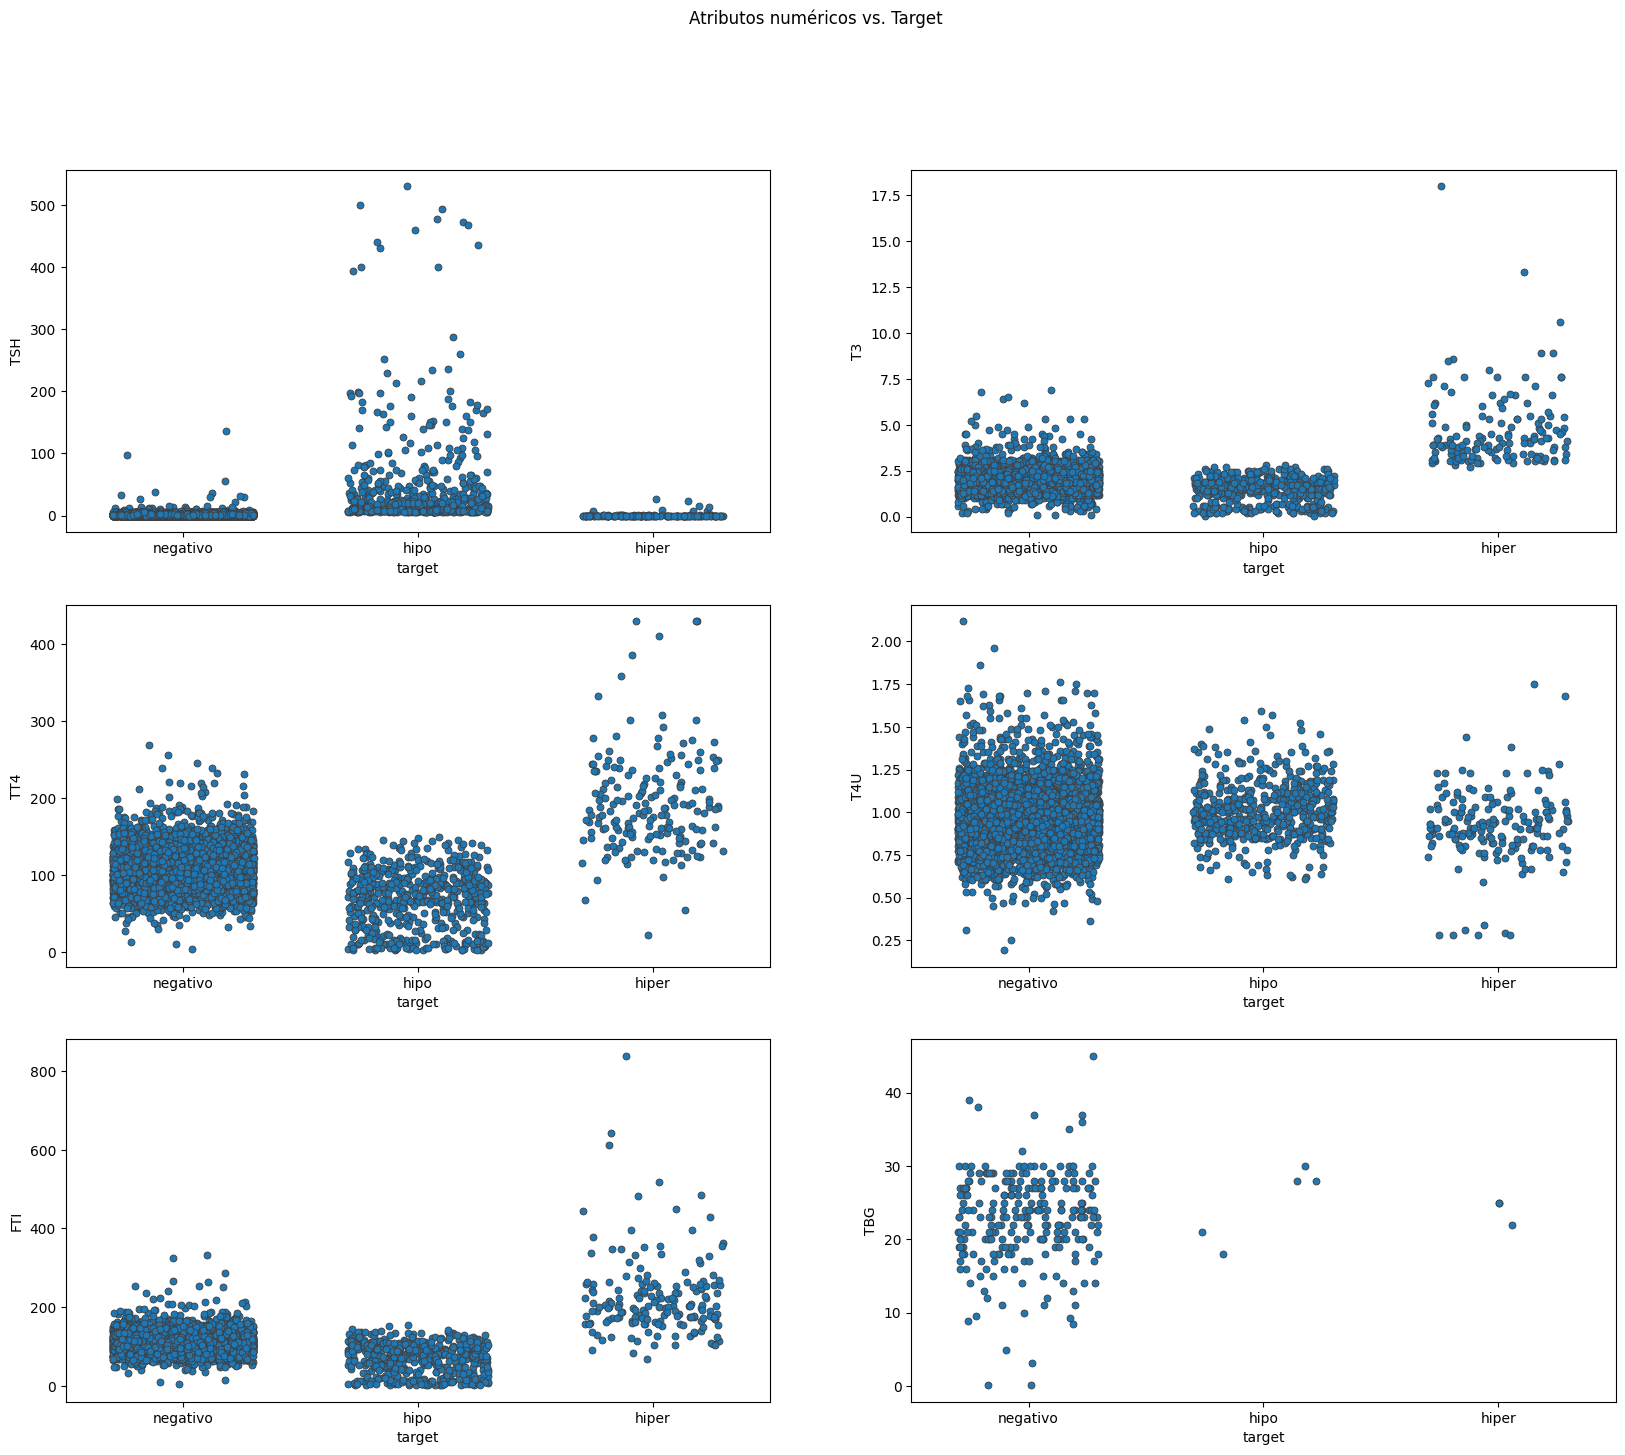

In [8]:
# Definindo um grid para multiplos gráficos seaborn
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Atributos numéricos vs. Target')
sns.set_style('whitegrid');

# TSH vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=thyroidDF.target, y=thyroidDF.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])

**Observações:**
- Imediatamente, podemos colocar a hipótese de que `FTI`, `T3`, e `TT4` serão bons preditores nos nossos modelos. O `TSH` parece que também pode ser bom, mas precisamos lidar com os outliers para o `'alvo'' hipo e analisar mais a distribuição de atributos antes de tomar qualquer decisão.
    - Tudo isso está em linha com o conhecimento descoberto sobre testes de nível hormonal durante nossa pesquisa inicial.

- Outro ponto que chamo a atenção é que num caso dicotômico a negação de uma variável dá lugar à verdade de outra variável. Veja o caso de `FTI`, por exemplo.

Vamos continuar, criando um diagrama em pares de nossas variáveis numéricas e ver se conseguimos detectar quaisquer agrupamentos que se formem entre as variáveis.

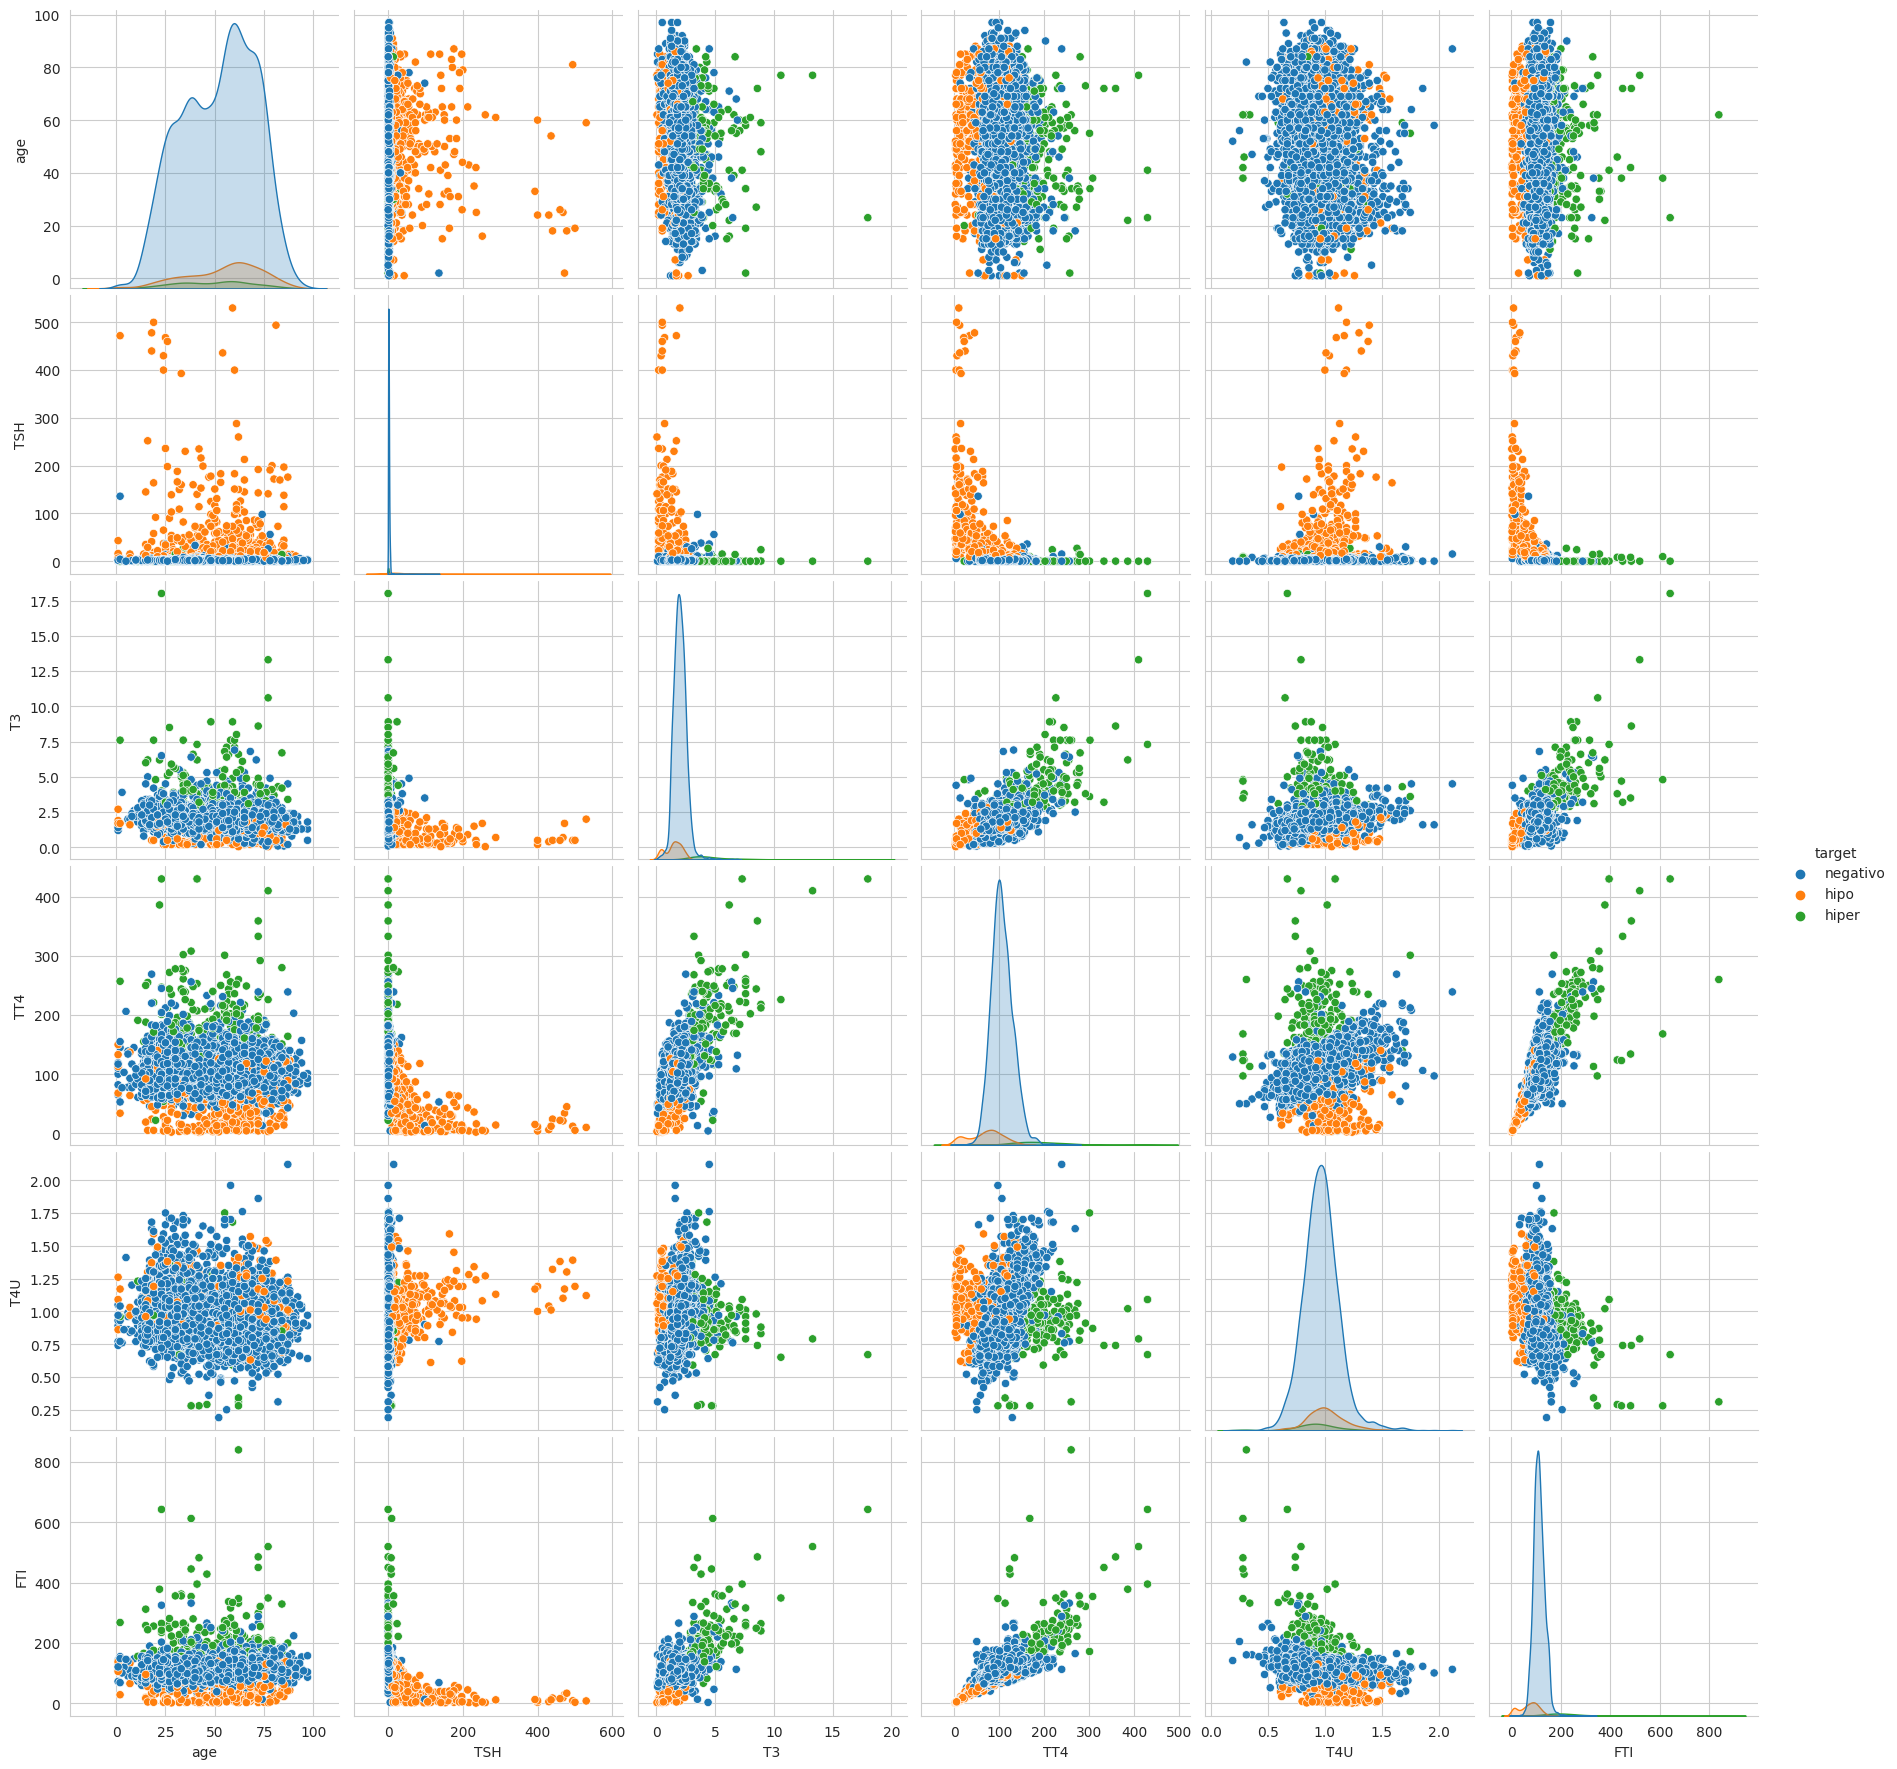

In [9]:
numericalDF = thyroidDF[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='target', height=3);
plt.show()

Nas diagonais do diagrama de pares, podemos ver as distribuições de cada variável numérica em relação umas às outras. É evidente como o conjunto de dados é desequilibrado, com tantos "alvos" negativos em comparação com o hipotiróide ou hipertiróide.<br>
_PS: para saber mais sobre dados desequilibrados, clica [aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/#:~:text=Severe%20Imbalance.,1%3A100%20or%20more)._

In [10]:
df_proportion = pd.DataFrame(thyroidDF.groupby('target')['target'].count())
df_proportion['proportion'] = (
    df_proportion['target'] / df_proportion['target'].min()
).round(0).astype(int)
print('A proporção entre as classes é de {:.0f}:{:.0f}:{:.0f}'.format(df_proportion['proportion'].tolist()[0]
                                                         , df_proportion['proportion'].tolist()[1]
                                                         , df_proportion['proportion'].tolist()[2]))

A proporção entre as classes é de 1:3:37


**Observações:**
- Podemos ver que para alguns testes hormonais vs. outros, existem bons grupos que se formam. Isto é encorajador porque significa que eles fazem um bom trabalho na separação de cada uma de nossas classes-alvo.
    - `FTI` vs `T3`
    - `FTI` vs `T4U`
    - `FTI` vs `idade`
    - `T4U` vs `TT4`
    - `TTT4` vs `idade`
    - `TT4` vs `T3`
- Há um grave desequilíbrio da classe alvo... mas nós sabíamos disso desde o início. É normal para este tipo de dado. Teremos que lidar com protocolo de reamostragem, assim como usar modelos que lidem bem com isto.

    - **XGBoost** seria uma boa opção

<a id='subsection-three-one'></a><span style="float:right">[Voltar](#section-zero)</span>
### Investigando correlações de variáveis

Agora vamos dar alguma atenção aos nossos outros atributos boleanos e dar uma olhada na correlação entre eles.

- Estamos utilizando o pacote 'dinton' como uma ferramenta de exploração de correlação multi-variada. Esta não é necessariamente a forma mais completa de explorar relações entre variáveis de diferentes tipos dentro de seu conjunto de dados, mas é direta e fácil de usar. Ela nos ajudará a ter uma idéia das correlações de variáveis mais tarde, enquanto realizamos a Análise Exploratória de Dados.

In [11]:
!pip install matplotlib --upgrade
import matplotlib

/home/bilhalvadiego/Documents/venvs/ds-env/lib/python3.10/site-packages/dython/nominal.py:668: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr.loc[:, columns[i]] = 0.0


TypeError: Image data of dtype object cannot be converted to float

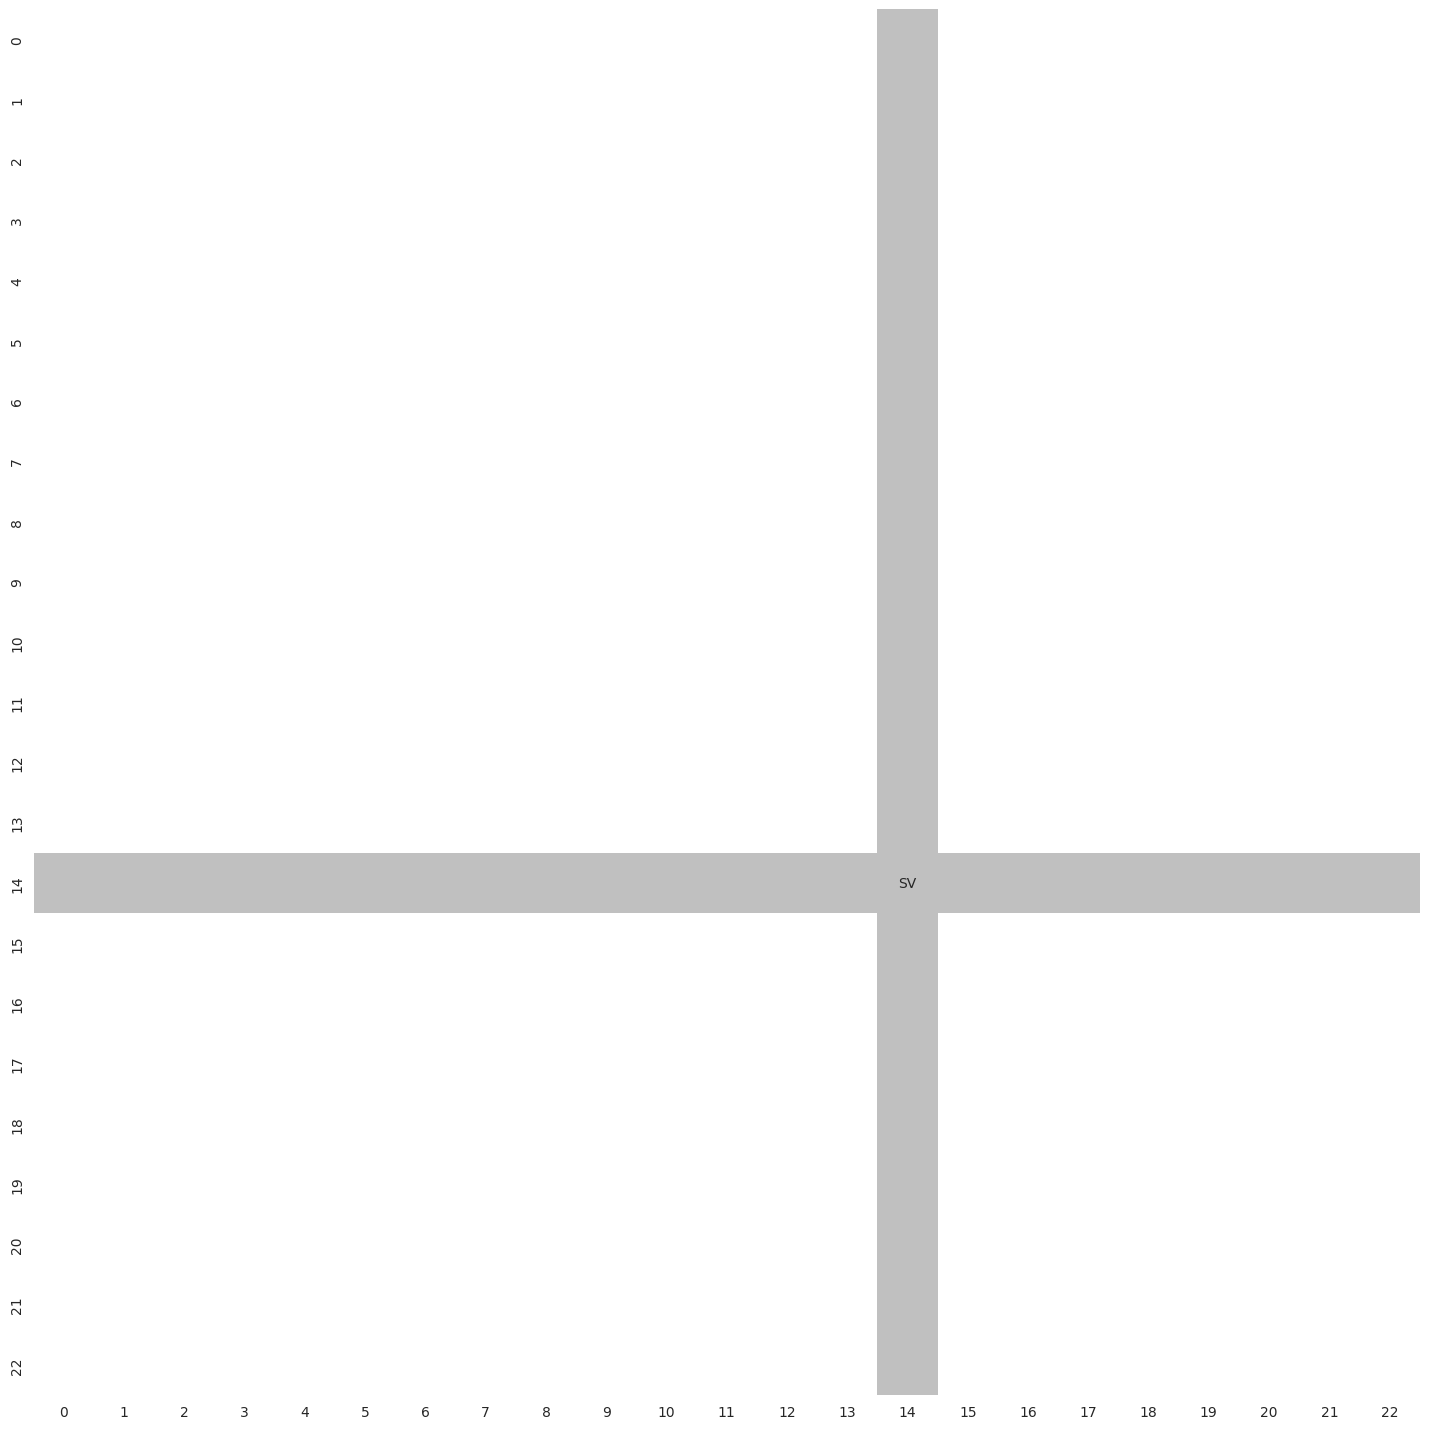

In [12]:
!pip install dython

import dython
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

categorical_features = identify_nominal_columns(thyroidDF)

associations(thyroidDF, 
            nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  
            ax=None, annot=True, fmt='.2f',cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, 
            compute_only=False, clustering=False, title=None, filename=None, 
            figsize=(18,18));

Muito bom ter todas estas informações sobre a correlação de todos os nossos atributos no mesmo lugar. Confirmamos imediatamente nossa hipótese de que os testes Hormonais são os mais úteis em nosso objetivo de prever o diagnóstico alvo. É surpreendente que quase nenhum outro de nossos atributos faça um bom trabalho na predição de nosso alvo. Decidiremos como seguir em frente com isto quando analisarmos um pouco mais.

**Observações:**
- Quando analisamos correlações devemos estar atentos à força desta correlação (quanto mais próximo do módulo de |1|, mais forte será esta correlação, bem como analisar o sentido desta correlação, que se positivo é diretamente proporcional e se negativo, inversamente proporcional. Por exemplo: esperamos que a "venda de guarda chuvas aumento em dias chuvosos", logo podemos dizer que esperamos que a correlação entre a venda de guarda chuvas em dias chuvosos tem seu valor próximo a +1. De maneira análoga, esperamos que aumento de combustíveis diminua o seu consumo, logo esta correlação teria o valor próximo a -1.

<a id='section-four'></a><span style="float:right">[Voltar](#section-zero)</span>
## Tratando Inconsistências
<a id='subsection-four-one'></a><span style="float:right">[Voltar](#section-zero)</span>
### Investigando Outliers

O código abaixo calcula as faixas interquartílicas para nossos atributos numéricos de teste Hormonal, a fim de determinar os outliers suaves e severos. Dependendo da gravidade do problema, decidiremos como lidar com eles na próxima seção.

In [ ]:
# TSH
Q1_TSH = thyroidDF['TSH'].quantile(0.25)
Q3_TSH = thyroidDF['TSH'].quantile(0.75)
IQR_TSH = Q3_TSH - Q1_TSH
under_TSH = thyroidDF['TSH'] < (Q1_TSH - 3 * IQR_TSH)
upper_TSH = thyroidDF['TSH'] > (Q3_TSH + 3 * IQR_TSH)
print('TSH:', 'outliers inferiores -', sum(under_TSH), ' | outliers superiores -', sum(upper_TSH))

# T3
Q1_T3 = thyroidDF['T3'].quantile(0.25)
Q3_T3 = thyroidDF['T3'].quantile(0.75)
IQR_T3 = Q3_T3 - Q1_T3
under_T3 = thyroidDF['T3'] < (Q1_T3 - 3 * IQR_T3)
upper_T3 = thyroidDF['T3'] > (Q3_T3 + 3 * IQR_T3)
print('T3:', 'outliers inferiores -', sum(under_T3), ' | outliers superiores -', sum(upper_T3))

# TT4
Q1_TT4 = thyroidDF['TT4'].quantile(0.25)
Q3_TT4 = thyroidDF['TT4'].quantile(0.75)
IQR_TT4 = Q3_TT4 - Q1_TT4
under_TT4 = thyroidDF['TT4'] < (Q1_TT4 - 3 * IQR_TT4)
upper_TT4 = thyroidDF['TT4'] > (Q3_TT4 + 3 * IQR_TT4)
print('TT4:', 'outliers inferiores -', sum(under_TT4), ' | outliers superiores -', sum(upper_TT4))

# T4U
Q1_T4U = thyroidDF['T4U'].quantile(0.25)
Q3_T4U = thyroidDF['T4U'].quantile(0.75)
IQR_T4U = Q3_T4U - Q1_T4U
under_T4U = thyroidDF['T4U'] < (Q1_T4U - 3 * IQR_T4U)
upper_T4U = thyroidDF['T4U'] > (Q3_T4U + 3 * IQR_T4U)
print('T4U:', 'outliers inferiores -', sum(under_T4U), ' | outliers superiores -', sum(upper_T4U))

# FTI
Q1_FTI = thyroidDF['FTI'].quantile(0.25)
Q3_FTI = thyroidDF['FTI'].quantile(0.75)
IQR_FTI = Q3_FTI - Q1_FTI
under_FTI = thyroidDF['FTI'] < (Q1_FTI - 3 * IQR_FTI)
upper_FTI = thyroidDF['FTI'] > (Q3_FTI + 3 * IQR_FTI)
print('FTI:', 'outliers inferiores -', sum(under_FTI), ' | outliers superiores -', sum(upper_FTI))

<a id='subsection-four-one-one'></a><span style="float:right">[Voltar](#section-zero)</span>
#### Plotando Boxplots

In [ ]:
# boxplots
fig, axs= plt.subplots(nrows = 5, figsize=(9,16))

# TSH
thyroidDF.boxplot(column='TSH', ax=axs[0], vert = False)
axs[0].axvline(x=(Q1_TSH - 3*IQR_TSH), color='r', linestyle='--')
axs[0].axvline(x=(Q3_TSH + 3*IQR_TSH), color='r', linestyle='--')
# T3
thyroidDF.boxplot(column='T3', ax=axs[1], vert = False)
axs[1].axvline(x=(Q1_T3 - 3*IQR_T3), color='r', linestyle='--')
axs[1].axvline(x=(Q3_T3 + 3*IQR_T3), color='r', linestyle='--')
# TT4
thyroidDF.boxplot(column='TT4', ax=axs[2], vert = False)
axs[2].axvline(x=(Q1_TT4 - 3*IQR_TT4), color='r', linestyle='--')
axs[2].axvline(x=(Q3_TT4 + 3*IQR_TT4), color='r', linestyle='--')
# T4U
thyroidDF.boxplot(column='T4U', ax=axs[3], vert = False)
axs[3].axvline(x=(Q1_T4U - 3*IQR_T4U), color='r', linestyle='--')
axs[3].axvline(x=(Q3_T4U + 3*IQR_T4U), color='r', linestyle='--')
# FTI
thyroidDF.boxplot(column='FTI', ax=axs[4], vert = False)
axs[4].axvline(x=(Q1_FTI - 3*IQR_FTI), color='r', linestyle='--')
axs[4].axvline(x=(Q3_FTI + 3*IQR_FTI), color='r', linestyle='--')

Parece que temos muitos outliers severos presentes. Entretanto, dadas nossas pesquisas sobre estes valores, este tipo de variação é normal dentro deste contexto e é de se esperar, especialmente quando lidamos com pessoas que terão alterações nestes valores dadas suas condições médicas.

<a id='subsection-four-two'></a><span style="float:right">[Voltar](#section-zero)</span>
### Investigando valores ausentes (Missing)

Primeiro faremos alguns cálculos para determinar a gravidade do nosso problema de valores ausentes. A função personalizada abaixo toma um _dataset_ como entrada e mantém uma contagem dos valores ausentes por coluna, depois calcula a porcentagem de valores ausentes naquela coluna e resume as informações em um _dataset_ de saída que é fácil para nós viabilizarmos.

- A ausência geral do nosso conjunto de dados é **7,54%***.
    - Isto parece preocupante no início, mas a maior parte desse volume é devido à coluna TBG que está quase totalmente vazia. Sabíamos que estávamos deixando isso de lado desde o início da análise, mas a mantivemos para fins de exploração. Agora é a hora de ir em frente e excluí-la do nosso _dataset_.
- A coluna "T3" é a segunda coluna mais ausente com **29,3%***. 
    - Trata-se de muitos dados que faltam e pode ser aconselhável remover, mas a coluna é muito importante para nossa análise (também fizemos pesquisas separadas que reiteraram que o T3 é um preditor muito importante para a doença da tireóide). Tentaremos imputar estas informações para o futuro.
- T3 é a terceira coluna mais ausente em **9,56%***.
    - Este é um bom candidato para a imputação avançar
- FTI" é nossa quarta coluna mais ausente em **8,86%***.
    - Este também é um bom candidato para imputação
- TT4" é nossa quinta coluna em **4,69%****.
    - Mais uma vez um bom candidato à imputação
- O "sexta" é nossa sexta coluna em **3,31%***.
    - Determinaremos o que fazer com o sexo mais tarde
        - dependendo de quão importante é manter em nosso conjunto de dados para fins de modelagem, tentaremos imputar
- A "idade" tem 4 valores em falta
    - criamos estes valores eliminando a idade inconsistente (muito grande) para estas observações
        - determinamos que podemos ir em frente e abandonar estas observações sem impactar nossa análise

**Observações:**
- Não parece uma coincidência que a maioria dos valores em falta sejam provenientes de exames de sangue.
    - Precisamos investigar isso mais a fundo para decidir a melhor abordagem para lidar com eles
        - Eles não estão lá porque não foram devidamente registrados ou porque nunca foram ordenados a serem tomados (considerados desnecessários pelos médicos)?
    - Determinaremos o que fazer com o sexo mais tarde
        - dependendo de quão importante é manter em nosso conjunto de dados para fins de modelagem, tentaremos imputar
- A "idade" tem 4 valores em falta
    - criamos estes valores eliminando a idade inconsistente (muito grande) para estas observações
        - determinamos que podemos ir em frente e abandonar estas observações sem impactar nossa análise

In [ ]:
# calculando missings
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('O percentual geral de missings é: {:.2f}%'.format(missingness * 100))

# Criando uma tabela para análise de missings
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Análise de missing data
missing_table(thyroidDF).head(10)

<a id='subsection-four-two-one'></a><span style="float:right">[Voltar](#section-zero)</span>
#### Sumário da tabela de dados faltantes

**thyroidDF[`TBG`]** - 96,56% em falta
- O atributo `TBG` está quase totalmente ausente do conjunto de dados. Esta coluna será removida imediatamente!

**thyroidDF[`age`]** - 0,045% em falta
- Também vamos em frente e deixar cair estas 4 observações do conjunto de dados. Todas estas 4 observações pertencem a observações com `target` == `negative`.

**thyroidDF[`Sex`]** - 3,37% em falta
- Há um total de 300 observações onde o `sex` é nulo. Em uma tentativa de preservar alguns desses valores, verificamos quantas dessas observações também têm `pregnant` == `True`. Há 3 observações deste tipo. Supondo que o atributo `pregnant` esteja correto para essas observações, podemos dizer com confiança que essas 3 observações pertencem às mulheres e podem mudar seus respectivos valores.

In [ ]:
# dropping 'TBG'
thyroidDF.drop(['TBG'], axis=1, inplace=True)

# dropping 4 observações anormais para a variável 'age'
thyroidDF.dropna(subset=['age'], inplace=True)

# alterando os valores sex das observações com ('pregnant' == True) & ('sex' == null) para Female
thyroidDF['sex'] = np.where((thyroidDF.sex.isnull()) & (thyroidDF.pregnant == 't'), 'F', thyroidDF.sex)

Agora vamos dar uma olhada nos valores em falta por linha. Se estamos avançando com a imputação, não queremos manter linhas que têm muitos valores faltantes (especialmente porque a maioria dos valores faltantes no conjunto de dados são dos atributos mais importantes).

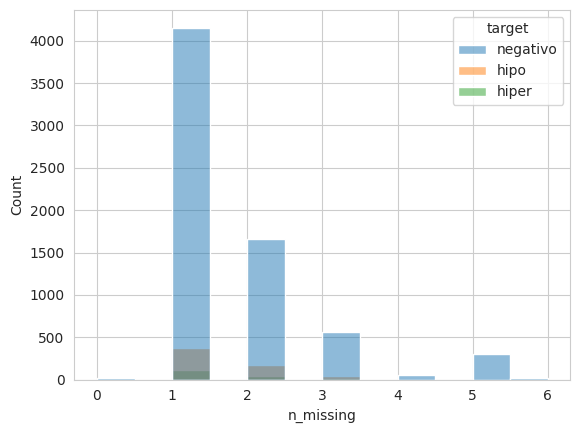

In [13]:
# count missing values por linha
thyroidDF['n_missing'] = thyroidDF.isnull().sum(axis=1)
sns.histplot(thyroidDF, x='n_missing', binwidth=0.5, hue='target');

Parece que, depois de remover `TBG` do conjunto de dados, a maioria das observações em nosso conjunto de dados tem zero valores ausentes. Muitos têm um valor faltante e alguns têm dois. uma minoria tem 3 ou mais. Antes de fazermos qualquer imputação, removeremos as observações que estão faltando dados para mais de 2 colunas. Isto é porque não queremos fazer observações juntas. Fazemos esta remoção no código abaixo, bem como geramos uma tabela final para os valores faltantes depois de termos tratado a maioria deles.

Estamos agora com apenas 2,89% de dados faltando em todo o conjunto de dados!

In [14]:
# calculando o total de missings
missingness = thyroidDF.isnull().sum().sum() / thyroidDF.count().sum()
print('O novo total geral de dados ausentes é: {:.2f}%'.format(missingness * 100))

# remover linhas com 3 ou mais valores ausentes
thyroidDF.drop(thyroidDF.index[thyroidDF['n_missing'] > 2], inplace=True)
# print
missing_table(thyroidDF).head(10)

O novo total geral de dados ausentes é: 7.20%


NameError: name 'missing_table' is not defined

Pronto! Agora vamos modelar!

---
<a id='section-five'></a><span style="float:right">[Voltar](#section-zero)</span>
## XGBoost Classifier

A [XGBoost](https://xgboost.readthedocs.io/en/stable/) tem algumas propriedades surpreendentes que a tornam extremamente adequada para nossos dados: 
- Ele pode lidar nativamente com valores ausentes nos dados, desde que os codifiquemos com 0.
- Ele faz um ótimo trabalho ao lidar com desequilíbrios severos de classes
    - especialmente com seu parâmetro "amostra_peso" para ajudar a combater o desequilíbrio pesado da classe alvo
- Ele pode selecionar as características mais importantes necessárias durante o treinamento e utiliza as de sua construção em árvore

PS: Para saber mais sobre o pacote **Sci-kit Learn**, cliqui [aqui](https://scikit-learn.org/stable/).
<a id='subsection-five-one'></a><span style="float:right">[Voltar](#section-zero)</span>
### Pré-processamento para XGBoost

In [19]:
# !pip3 install xgboost

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

SEED = 5252

# substituição de strings booleanas por binários 0 e 1
thyroidDF.replace('f', 0, inplace=True)
thyroidDF.replace('t', 1, inplace=True)

# substituição dos sexos por 0 e 1
thyroidDF.replace('M', 0, inplace=True) # male mapped to 0
thyroidDF.replace('F', 1, inplace=True) # female mapped to 1

xgbDF = thyroidDF.replace(np.nan, 0)

# re-mapping dos valores target groupos de diagnóstico
diagnoses = {'negativo': 0,
             'hipo': 1, 
             'hiper': 2}

xgbDF['target'] = xgbDF['target'].map(diagnoses) # re-mapping

# train and test split --> stratified
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [21]:
X.to_csv('x_thyroid.csv')
y.to_csv('y_thyroid.csv')

<a id='subsection-five-two'></a><span style="float:right">[Voltar](#section-zero)</span>
### XGBoost model v1

**Termos**:
1. `mloglos`: conhecida como perda logística ou perda de centros de gravidade cruzados. Esta é a função de perda usada na regressão logística (multinomial) e extensões da mesma, tais como redes neurais, definidas como a probabilidade logística negativa de um modelo logístico que retorna as probabilidades y_pred para seus dados de treinamento y_true.

1. `merror`: é a taxa de erro de classificação multiclasse.

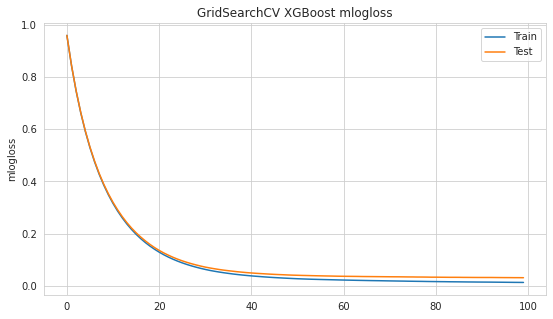

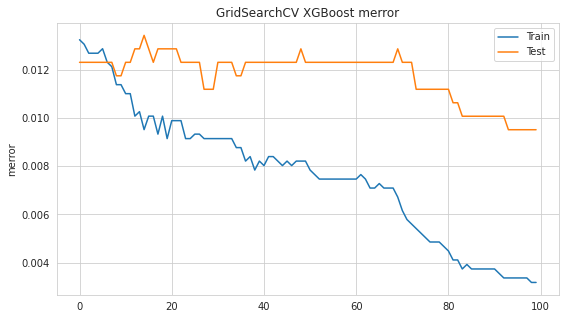


------------------ Confusion Matrix -----------------

[[1588    5    4]
 [   0  145    0]
 [   8    0   36]]

-------------------- Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.94

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.95
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.90      0.82      0.86        44

    accuracy                           0.99      1786
   macro avg       0.95      0.94      0.94      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [22]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=SEED)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

<a id='subsection-five-three'></a><span style="float:right">[Voltar](#section-zero)</span>
### XGBoost model v2

- https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters
- https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=XGBClassifier#xgboost.XGBClassifier

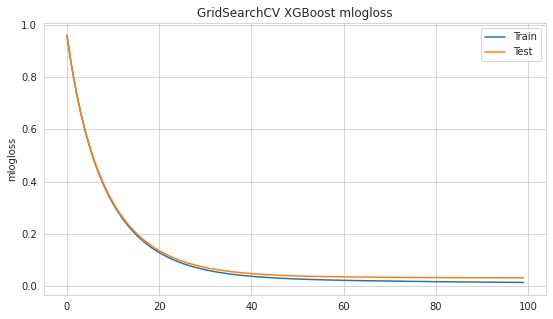

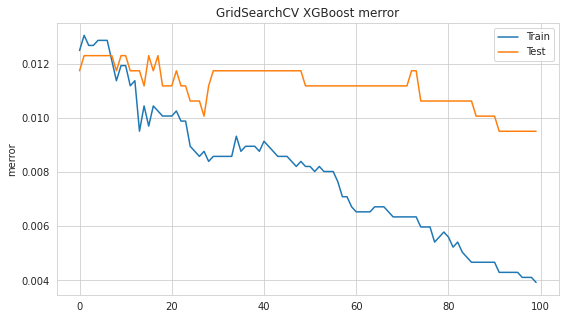


------------------ Confusion Matrix -----------------

[[1588    5    4]
 [   0  145    0]
 [   8    0   36]]

Accuracy: 0.99
Balanced Accuracy: 0.94

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.95
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.90      0.82      0.86        44

    accuracy                           0.99      1786
   macro avg       0.95      0.94      0.94      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [23]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=0,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=SEED)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

<a id='subsection-five-four'></a><span style="float:right">[Voltar](#section-zero)</span>
### XGBoost Model v3

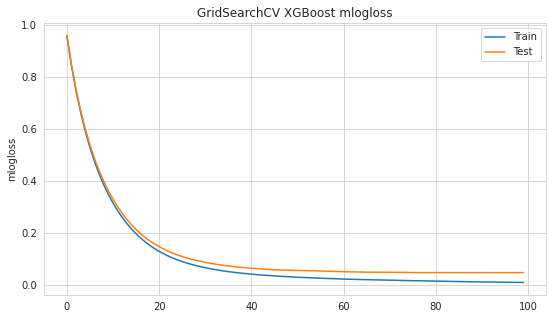

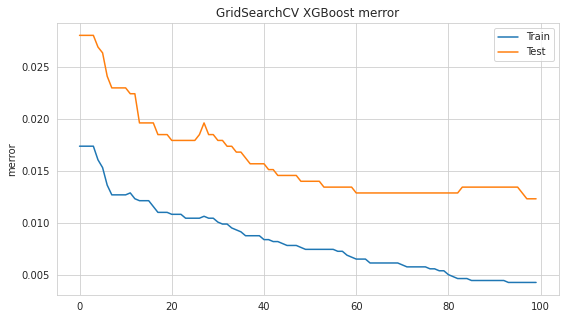


------------------ Confusion Matrix -----------------

[[1578    7   12]
 [   0  145    0]
 [   3    0   41]]

Accuracy: 0.99
Balanced Accuracy: 0.97

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.91
Macro Recall: 0.97
Macro F1-score: 0.94

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.95      1.00      0.98       145
           2       0.77      0.93      0.85        44

    accuracy                           0.99      1786
   macro avg       0.91      0.97      0.94      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [24]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=SEED)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

In [25]:
# print(X_train.columns)

exemplo = X_train.iloc[4].to_dict()

exemplo = {k:[v] for k,v in exemplo.items()}  # WORKAROUND
df = pd.DataFrame(exemplo)
df

# y_train

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,n_missing
0,64.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.2,0.0,111.0,0.97,114.0,1.0


In [26]:
y_train.iloc[4]

0

In [27]:
xgb_clf.predict(df)

array([0])

In [28]:
import pickle

# Saving model to disk
pickle.dump(xgb_clf, open('xgb_clf.pkl','wb'))
# Loading model to compare the results
# modelo = pickle.load(open('xgb_clf.pkl','rb'))
# print(modelo.predict(df))

**Observação** <br>
Micro e macro recall (para qualquer métrica) calcularão coisas ligeiramente diferentes e, portanto, sua interpretação difere. Uma macrométrica calculará a métrica independentemente para cada classe e então tomará a média (tratando assim todas as classes igualmente), enquanto uma micrométrica agregará as contribuições de todas as classes para calcular a métrica média. Em uma classificação multiclasse, a micro-medida é preferível se você suspeitar que pode haver um desequilíbrio de classe (ou seja, você pode ter muito mais exemplos de uma classe do que de outras classes).

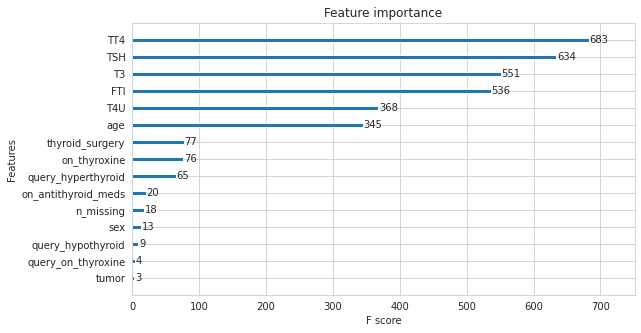

In [ ]:
## ---------- Plot Feature Importance ----------
## plotting feature importance of best xgboost model (v3)

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

In [2]:
!pip install Graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.6 MB/s eta 0:00:00


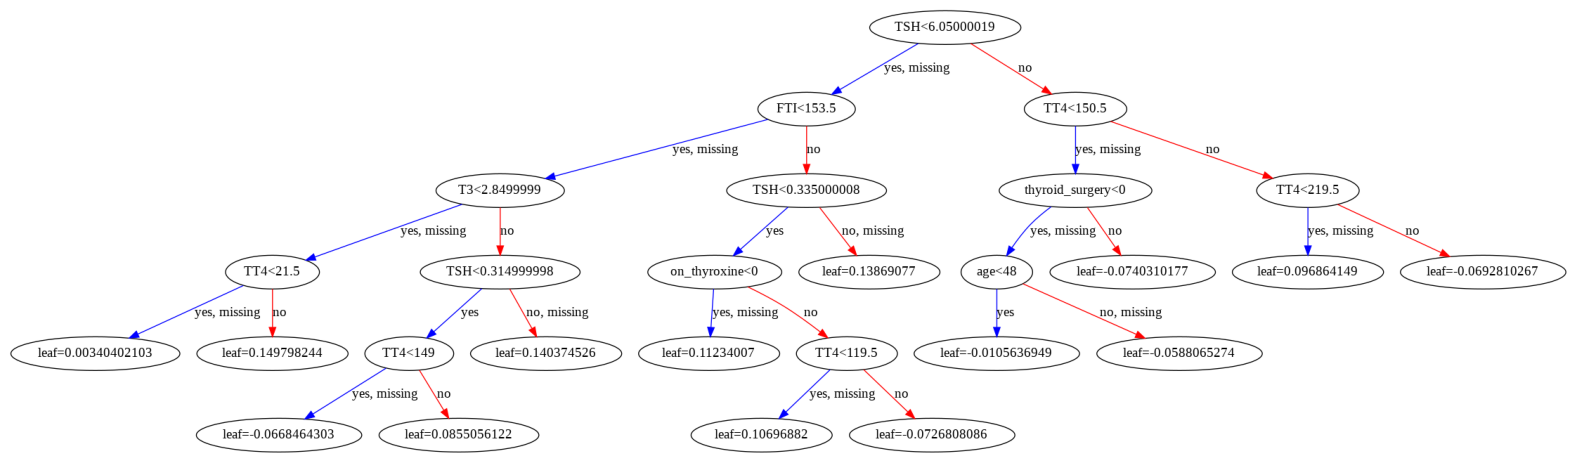

In [ ]:
## ---------- Plot Model Tree ----------
## plotting model tree of best xgboost model (v3)

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 28,12
xgb.plot_tree(xgb_clf)
plt.show()

<a id='section-six'></a><span style="float:right">[Voltar](#section-zero)</span>
## Escolhendo variáveis: uma ótica estatística

Aqui apresento uma construção iterativa passo a passo de um modelo de regressão que envolve a seleção de variáveis independentes para serem usadas em um modelo final. Envolve a adição ou remoção de potenciais variáveis explicativas em sucessão e testes de significância estatística após cada iteração.

In [ ]:
# !pip install lxml

In [ ]:
import statsmodels.formula.api as smf
import diegobilhalva_tools as dbtools

tools = dbtools.diegobilhalva_tools()

ModuleNotFoundError: ignored

In [ ]:
cols = xgbDF.columns[0:xgbDF.shape[1]-2]
cols

In [ ]:
formulaRaw = tools.formulaRawAuto(X=cols, y='target')
formulaRaw

In [ ]:
modelo = smf.ols(data = xgbDF, formula = formulaRaw)
modelo_ajustado = modelo.fit()
print(modelo_ajustado.summary())

In [ ]:
formula, listCol = tools.formulaStepWise(dados=xgbDF, formulaRaw=formulaRaw, y= 'diagnoses', significancia=.05)
print(listCol)
print(len(listCol))
print(len(xgbDF.columns))

<a id='section-seven'></a><span style="float:right">[Voltar](#section-zero)</span>
## Conclusão

Você deve ter acompanhado comigo a importância de uma boa análise preliminar, antes, porém, ter de se fazer uma diligente imersão, ainda que não tão produnda, no contexto que o conjunto de dados se insere. Ao se analisar este _dataset_ trouxe aspectos importantes de definição dos diferentes tipos de doenças da tireóide, bem como os exames e leituras adequadas dos valores que podem se apresentar. 

Explorando o conjunto de dados e documentando todas as abordagens da análise, o analista traz luz ao que experar para a modelagem, criando um plano coerente, enxuto e com narrativa boa o suficiente para adaptar-se às adversidades que poderá encontrar, relacionando todos os objetos de estudo ao tema que foi previamente pesquisado.

Destaco, também, que durante a análise exploratória se faça um bom uso de gráficos afim de rapidamente e de modo visual se tenha a noção de como os casos se comportam no campo de estudo. Aliás, foi pela análise exploratória visual que tivemos o primeiro _insight_ por optar pelo método de classificação `XGBoost`. Aliás, você se lembra do porquê escolhemos este método? Isso mesmo, foi porque temos uma variável alvo com classes desequilibradas: A proporção entre as classes foi de 1:3:37 entre os diferentes valores.

Outro ponto a ser considerado é a análise de _outliers_, mas devido a característica desequilibrada dos dados, aspectos inerentes à massa de dados que estamos estudando e, principalmente o foco deste trabalho, optamos por mantê-los na análise, sem causar prejuízo à natureza e resultados deste estudo. Um pensamento estruturado e objetivo facilita nestas horas, não é verdade?

Ainda precisamos comentar sobre os _missing values_ encontrados e como foi importante a exclusão da variável `TBG`. Você lembra o que aconteceu com o nosso _dataset_ após este procedimento?

Por fim, o modelo `XGBoost` foi executado em 3 modos diferentes: `standard`, `otimizado` e `otimizado, considerando o desequilíbrio`. Você pode comentar sobre os resultados obtidos em cada um dos casos?